In [1]:
from envs import TicTacToeTrainingEnv
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from sb3_contrib.ppo_mask import MaskablePPO
from utils.terminal_colors import *
from utils.json_utils import save_opponent_stats, load_opponent_stats
from utils.agents_utils import should_save_agent, get_agents, get_last_agent_number
from utils.evaluator import evaluate_agent_by_opponent
from utils.visualize import defeat_rate_plot
from training.config import *
from sb3_contrib.common.wrappers import ActionMasker
from utils.action_mask_ import mask_fn
import json

<h1 style="color:#0b9ed8">TRAINING</h1>

In [2]:
def create_env(opponent_pool):
    """
    Create and wrap the TicTacToe training environment once per training session.

    Parameters:
    -----------
    opponent_pool : list of opponent names or agents against which the agent will train.

    Returns:
    --------
    env : ActionMasker
        Wrapped TicTacToe environment ready for training.
    """
    env_init = TicTacToeTrainingEnv(
        board_length=TRAINING_DEFAULT_BOARD_LENGTH,
        pattern_victory_length=TRAINING_DEFAULT_PATTERN_VICTORY_LENGTH,
        opponent_pool=opponent_pool,
        first_play_rate=TRAINING_DEFAULT_FIRST_PLAY_RATE,
        lost_games_path=DEFEAT_PATH,
        review_ratio=TRAINING_DEFAULT_REVIEW_RATIO,
        opponent_statistics_file=BEST_STATS_PATH,
    )
    env = ActionMasker(env_init, mask_fn)
    env.reset()
    return env

In [3]:
def initialize_agent(env, last_agent_num, ent_coef, n_steps, batch_size, learning_rate):
    """
    Initialize or load the PPO agent. Updates dynamic training parameters if agent exists.

    Parameters:
    -----------
    env : ActionMasker
        The training environment.
    last_agent_num : int
        The number of the last saved agent.
    ent_coef : float
        Entropy coefficient for exploration.
    n_steps : int
        Number of steps to run for each environment per update.
    batch_size : int
        Size of minibatches for training.
    learning_rate : float
        Learning rate for training.

    Returns:
    --------
    agent : MaskablePPO
        Initialized or loaded PPO agent.
    """
    checkpoint_path = os.path.join(AGENTS_DIR, "last_checkpoint.zip")

    if os.path.exists(checkpoint_path):
        agent = MaskablePPO.load(checkpoint_path, env=env)
        print("✅ Loaded agent from last checkpoint.")
    elif last_agent_num == 0:
        agent = MaskablePPO(
            "MultiInputPolicy",
            env=env,
            verbose=1,
            gamma=GAMMA,
            gae_lambda=GAE_LAMBDA,
            ent_coef=ent_coef,
            n_steps=n_steps,
            batch_size=batch_size,
            learning_rate=learning_rate,
            policy_kwargs=policy_kwargs
        )
    else:
        prev_agent_path = get_agents(AGENTS_DIR)[-1]
        agent = MaskablePPO.load(prev_agent_path, env=env)

    # Update dynamic parameters
    agent.ent_coef = ent_coef
    agent.n_steps = n_steps
    agent.batch_size = batch_size
    agent.learning_rate = learning_rate
    return agent

In [4]:
def train_one_agent():
    """
    Train a single PPO agent, evaluate against opponents, and save stats continuously.

    Returns:
    --------
    improvement : bool
        True if agent shows improvement over previous best.
    """
    last_agent_num = get_last_agent_number(AGENTS_DIR)
    next_agent_num = last_agent_num + 1
    agent_name = f"agent_v{next_agent_num}_{BASE_AGENTS_NAME}.zip"
    agent_path = os.path.join(AGENTS_DIR, agent_name)

    opponent_agents = get_agents(AGENTS_DIR)
    opponent_pool = ["random", "smart_random"] + opponent_agents
    improvement = False
    best_stats = load_opponent_stats(opponent_pool)
    n_checks = TOTAL_STEPS // CHECKPOINT_INTERVAL

    env = create_env(opponent_pool)

    for check in range(n_checks):
        current_progress = (check * CHECKPOINT_INTERVAL) / TOTAL_STEPS

        # Dynamic training parameters
        n_steps = int(2048 + (4096 - 2048) * current_progress**0.8)
        batch_size = min(1024, int(512 + (2048 - 512) * current_progress**1.0))
        ent_coef = 0.02
        learning_rate = LR_SCHEDULE(current_progress)

        if check == 0:
            agent = initialize_agent(env, last_agent_num, ent_coef, n_steps, batch_size, learning_rate)

        print(f"\n{YELLOW}=== Training segment {check+1}/{n_checks} ===")
        print(f"Steps: {check*CHECKPOINT_INTERVAL}-{(check+1)*CHECKPOINT_INTERVAL}")
        print(f"Params: n_steps={n_steps}, batch={batch_size}, ent_coef={ent_coef:.4f}")
        print(f"Opponents: {opponent_pool}{RESET}\n")

        # Train agent
        agent.learn(total_timesteps=CHECKPOINT_INTERVAL)

        # Evaluate agent
        results = evaluate_agent_by_opponent(agent, opponent_pool, n_episodes=10000)
        current_stats = {k: {"defeat_rate": v["defeat_rate"], "victory_rate": v["victory_rate"]} for k, v in results.items()}

        # Save improvement if criteria met
        if should_save_agent(current_stats, best_stats, IMPROVEMENT_THRESHOLD):
            print(f"{GREEN}Saved new best agent at checkpoint {check}{RESET}")
            improvement = True
            best_stats = deepcopy(current_stats)
            agent.save(agent_path)
            save_opponent_stats(best_stats, BEST_STATS_PATH)

        # Save all stats to JSON file continuously
        all_stats_data = {}
        if os.path.exists(ALL_STATS_PATH):
            with open(ALL_STATS_PATH, "r") as f:
                all_stats_data = json.load(f)

        # Determine the next checkpoint index based on existing entries
        next_checkpoint = len(all_stats_data) + 1

        # Store current evaluation for this checkpoint
        all_stats_data[f"checkpoint_{next_checkpoint}"] = {
            opp: {
                "overall_defeat_rate": results[opp]["defeat_rate"],
                "first_player_defeat_rate": results[opp]["losses_play_first"] / 5000,
                "second_player_defeat_rate": results[opp]["losses_play_second"] / 5000 ,
            }
            for opp in opponent_pool
        }


        with open(ALL_STATS_PATH, "w") as f:
            json.dump(all_stats_data, f, indent=4)

        # Early stopping if all defeat rates are zero
        all_defeat_zero = all(stats["defeat_rate"] == 0.0 for stats in current_stats.values())
        if all_defeat_zero:
            print(f"{GREEN}=== All defeat rates are 0. Early stopping triggered. ==={RESET}")
            break

    agent.save(os.path.join(AGENTS_DIR, "last_checkpoint.zip"))
    return improvement

In [5]:
def main_training_loop(nb_agents_to_train=5):
    """
    Main training loop to train multiple PPO agents sequentially.

    Parameters:
    -----------
    nb_agents_to_train : int
        Number of agents to train in this session.

    Returns:
    --------
    None
    """
    trained_count = 0
    while trained_count < nb_agents_to_train:
        improvement = train_one_agent()  # now returns only improvement
        if improvement:
            print(f"{GREEN}Training completed for agent {trained_count+1}. Best agent saved.{RESET}")
        else:
            print(f"{RED}Warning: No agent met improvement criteria{RESET}")
        trained_count += 1  # continue to next agent regardless


In [6]:
 # Run the training loop
main_training_loop(3)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

=== Training segment 1/10 ===
Steps: 0-10000
Params: n_steps=2048, batch=512, ent_coef=0.0200
Opponents: ['random', 'smart_random']

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.41     |
|    ep_rew_mean     | -0.454   |
| time/              |          |
|    fps             | 334      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.19         |
|    ep_rew_mean          | -0.409       |
| time/                   |              |
|    fps                  | 322          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
| 

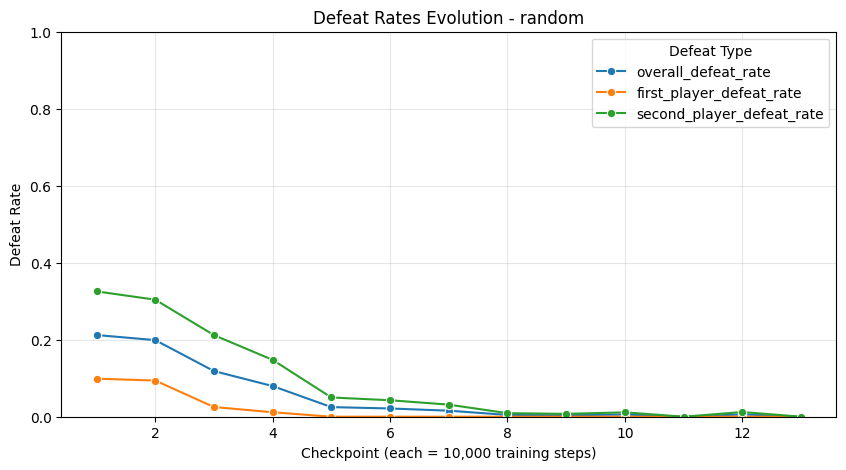

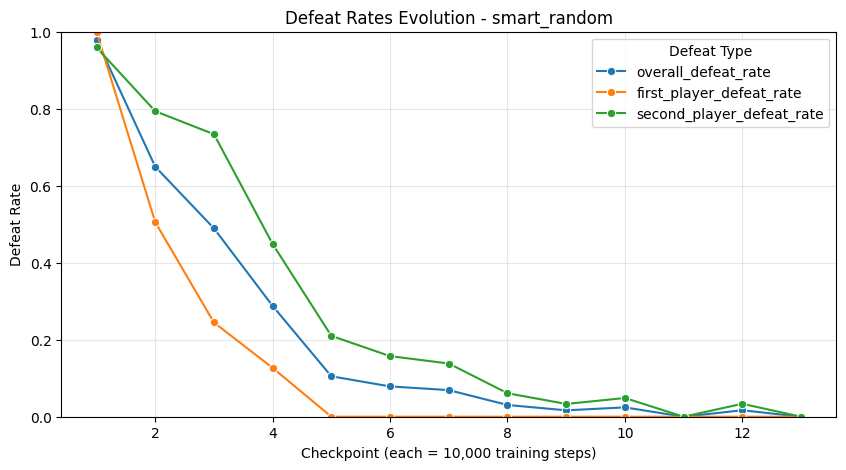

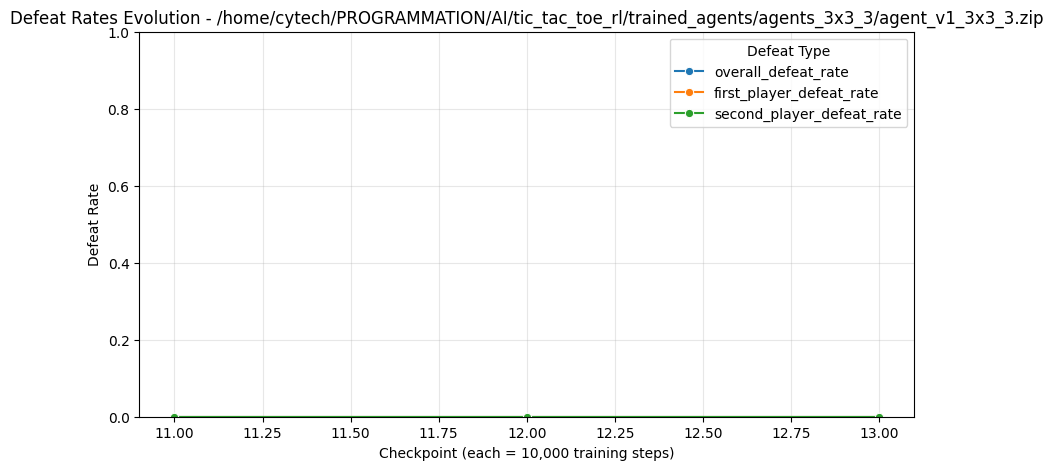

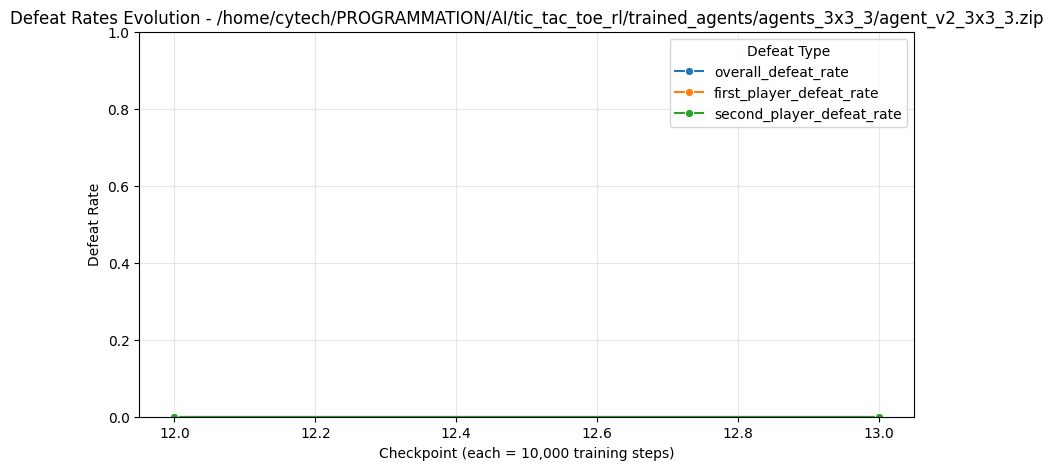

In [7]:
defeat_rate_plot()

In [8]:
a = "agent_v1_3x3.zip"
int(a[7])

1